In [38]:
import sys
sys.path.append('../deepsurv')
import deepsurv

#from deepsurv_logger import DeepSurvLogger, TensorboardLogger
import utils
import viz
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import lasagne
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline


In [16]:
train_dataset_fp = 'df_prognosis_features_ready.tsv'
train_df = pd.read_table(train_dataset_fp)


In [131]:
def dataframe_to_deepsurv_ds(df, event_col = 'os_status', time_col = 'os'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    #x=x_df
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }


In [184]:
### Min Max Scaler Normalization and good format of the data to feed the MLP network
scale = preprocessing.MinMaxScaler().fit(train)
df_train = pd.DataFrame(scale.transform(train.values), columns=train.columns, index=train.index)
df_test = pd.DataFrame(scale.transform(test.values), columns=test.columns, index=test.index)
train_data = dataframe_to_deepsurv_ds(df_train, event_col = 'os_status', time_col= 'os')
val_data = dataframe_to_deepsurv_ds(df_test, event_col = 'os_status', time_col= 'os')

/Users/taziy/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [185]:
hyperparams = {
    'L2_reg': 10.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [100,10],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    #'standardize': True
}
#activation:"selu"
'''
        self.hyperparams = {
            'n_in': n_in,
            'learning_rate': learning_rate,
            'hidden_layers_sizes': hidden_layers_sizes,
            'lr_decay': lr_decay,
            'momentum': momentum,
            'L2_reg': L2_reg,
            'L1_reg': L1_reg,
            'activation': activation,
            'dropout': dropout,
            'batch_norm': batch_norm,
            'standardize': standardize
        }
'''

"\n        self.hyperparams = {\n            'n_in': n_in,\n            'learning_rate': learning_rate,\n            'hidden_layers_sizes': hidden_layers_sizes,\n            'lr_decay': lr_decay,\n            'momentum': momentum,\n            'L2_reg': L2_reg,\n            'L1_reg': L1_reg,\n            'activation': activation,\n            'dropout': dropout,\n            'batch_norm': batch_norm,\n            'standardize': standardize\n        }\n"

In [215]:
np.random.seed(17)
network = deepsurv.DeepSurv(**hyperparams)
network.restored_update_params = None 
logger = deepsurv.deepsurv_logger.TensorboardLogger(name = 'DeepSurvLogger', logdir = './logs/tensorboard/')
np.random.seed(17)
update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. 
n_epochs = 500
val_frequency=250
patience=2000 # minimum number of epochs to train for
metrics =  network.train(train_data,val_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn,patience=patience,validation_frequency=val_frequency)

2019-05-14 12:05:03,870 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 12:05:03,870 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 12:05:03,870 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 12:05:03,870 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 12:05:29,973 - Training step 250/500 |************             | - loss: 12.4677 - ci: 0.4602
2019-05-14 12:05:29,973 - Training step 250/500 |************             | - loss: 12.4677 - ci: 0.4602
2019-05-14 12:05:29,973 - Training step 250/500 |************             | - loss: 12.4677 - ci: 0.4602
2019-05-14 12:05:29,973 - Training step 250/500 |************             | - loss: 12.4677 - ci: 0.4602
2019-05-14 12:05:57,458 - Finished Training with 500 iterations in 53.78s
2019-05-14 12:05:57,458 - Finished Training with 500 iterations in 53.78s
2019-05-14 1

In [214]:
network.save_model("deep_surv_model_500_epochs", weights_file ="deep_surv_weights_500_epochs")
previous_model = deepsurv.deep_surv.load_model_from_json(model_fp = 'deep_surv_model_500_epochs' , weights_fp =     'deep_surv_weights_500_epochs')
previous_model.get_concordance_index(x=val_data['x'],t=val_data['t'],e=val_data['e'])

Loading json model: {"n_in": 178, "learning_rate": 1e-05, "hidden_layers_sizes": [100, 10], "lr_decay": 0.001, "momentum": 0.9, "L2_reg": 10.0, "L1_reg": 0.0, "activation": "rectify", "dropout": 0.4, "batch_norm": true, "standardize": false}


0.44322067913622865

In [187]:
np.random.seed(17)
model = deepsurv.DeepSurv(**hyperparams)

# DeepSurv can now leverage TensorBoard to monitor training and validation
# This section of code is optional. If you don't want to use the tensorboard logger
# Uncomment the below line, and comment out the other three lines: 
# logger = None

experiment_name = 'test_experiment_sebastian'
logdir = './logs/tensorboard/'
logger = deepsurv.deepsurv_logger.TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
np.random.seed(17)
update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                            # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                            # for other optimizers to use
n_epochs = 500
val_frequency=250
patience=2000 # minimum number of epochs to train for
# If you have validation data, you can add it as the second parameter to the function

metrics = model.train(train_data,val_data, n_epochs=n_epochs, logger=logger, update_fn=update_fn,patience=patience,validation_frequency=val_frequency)

2019-05-14 11:18:32,342 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 11:18:32,342 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 11:18:32,342 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 11:18:32,342 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 11:18:32,342 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 11:18:32,342 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 11:18:32,342 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 11:18:32,342 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 11:18:32,342 - Training step 0/500   |                         | - loss: 22.0443 - ci: 0.4373
2019-05-14 11:18:32,342 - Training step 0/500   |      

In [216]:
metrics['valid_c-index']

[(0, 0.4391265954884804), (250, 0.4491450590029702)]

In [217]:
metrics['best_valid_loss']

array(10.96796368)

Train C-Index: (499, 0.4681709875707654)


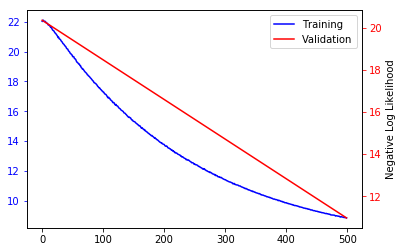

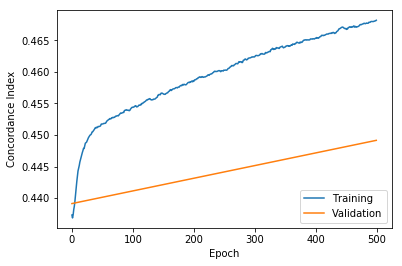

In [218]:

# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

# Plot the training / validation curves
deepsurv.viz.plot_log(metrics)